In [1]:
import json
import numpy as np
import xobjects as xo
import xtrack as xt
import xpart as xp
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy import constants 
####################
# Choose a context #
####################
context = xo.ContextCpu()
# context = xo.ContextCpu(omp_num_threads='auto')
buf = context.new_buffer()

# Ion properties:
m_u = 931.49410242e6 # eV/c^2 -- atomic mass unit
A = 207.98 # Lead-208
Z = 82  # Number of protons in the ion (Lead)
Ne = 3 # Number of remaining electrons (Lithium-like)
q0=Z-Ne
m_e = 0.511e6 # eV/c^2 -- electron mass
m_p = 938.272088e6 # eV/c^2 -- proton mass
clight = 299792458.0 # m/s

m_ion = A*m_u + Ne*m_e # eV/c^2
equiv_proton_momentum = 236e9 # eV/c = gamma_p*m_p*v
gamma_p = np.sqrt( 1 + (equiv_proton_momentum/m_p)**2 ) # equvalent gamma for protons in the ring

p0c = equiv_proton_momentum*(q0) # eV/c
gamma = np.sqrt( 1 + (p0c/m_ion)**2 ) # ion relativistic factor
beta = np.sqrt(1-1/(gamma*gamma)) # ion beta


/home/pkruyt/cernbox/xsuite-laser/xtrack/xtrack/progress_indicator.py:90: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
#%%
##################
# Build TrackJob #
##################

fname_sequence ='/home/pkruyt/cernbox/xsuite-env/xtrack/test_data/sps_w_spacecharge/line_no_spacecharge_and_particle.json'

with open(fname_sequence, 'r') as fid:
     input_data = json.load(fid)
SPS_line = xt.Line.from_dict(input_data['line'])

n_part = int(1e4)

# SPS_tracker = xt.Tracker(_context=context, _buffer=buf, line=sequence)

# Build a reference particle
particle_sample = xp.Particles(mass0=m_ion, q0=q0, p0c=p0c)

nemitt = 1.5e-6 # m*rad (normalized emittance)
sigma_z = 0.063 # m

SPS_line.particle_ref = particle_sample
twiss = SPS_line.twiss(symplectify=True)

twiss_dict=dict(twiss)

#%%
###################
# Linear Transfer #
###################

qx=twiss['qx']
qy=twiss['qy']
dqx=twiss['dqx']
dqy=twiss['dqy']
circumference=twiss['s'][-1]
# beta_x=twiss['betx'][-1]
# beta_y=twiss['bety'][-1]


qs=twiss['qs']
bets=twiss['betz0']


#at interaction points:
beta_x  =  54.614389 # m
beta_y  =  44.332517 # m
alpha_x = -1.535235
alpha_y =  1.314101


arc = xt.LineSegmentMap(
        qx=qx, qy=qy,
        dqx=0, dqy=0,
        length=circumference,
        alfx=alpha_x,
        alfy=alpha_y,
        betx=beta_x,
        bety=beta_y,
        qs=qs,
        bets=bets
        )


T_per_turn = circumference/(clight*beta)

Loading line from dict:   0%|          | 0/11600 [00:00<?, ?it/s]

Done loading line from dict.           
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


In [3]:
sigma_x = 1.047e-3 # m
sigma_y = 0.83e-3  # m
sigma_dp = 2e-4 # relative ion momentum spread


particles0 = xp.generate_matched_gaussian_bunch(
        num_particles=n_part,
        #total_intensity_particles=bunch_intensity,
        nemitt_x=nemitt, nemitt_y=nemitt, sigma_z=sigma_z,
        #R_matrix=r_matrix,
        particle_ref=particle_sample,
        line=SPS_line
        #,steps_r_matrix=steps_r_matrix
        )


*** Maximum RMS bunch length 0.23592919520901076m.
... distance to target bunch length: -6.3000e-02
... distance to target bunch length: 1.6641e-01
... distance to target bunch length: 7.8199e-02
... distance to target bunch length: -3.6997e-03
... distance to target bunch length: -7.6444e-05
... distance to target bunch length: -2.4567e-08
... distance to target bunch length: 3.0249e-07
--> Bunch length: 0.06299997543345463
--> Emittance: 0.06216653183600112


In [4]:
##################
# Laser Cooler #
##################


#laser-ion beam collision angle
theta_l = 2.6*np.pi/180 # rad
# theta_l = 0
nx = 0; ny = -np.sin(theta_l); nz = -np.cos(theta_l)

# Ion excitation energy:
hw0 = 230.823 # eV
hc=constants.hbar*clight/constants.e # eV*m (ħc)
lambda_0 = 2*np.pi*hc/hw0 # m -- ion excitation wavelength

lambda_l = lambda_0*gamma*(1 + beta*np.cos(theta_l)) # m -- laser wavelength

# Shift laser wavelength for fast longitudinal cooling:5
# lambda_l = lambda_l*(1+1*sigma_dp) # m

laser_frequency = clight/lambda_l # Hz
sigma_w = 2*np.pi*laser_frequency*sigma_dp
#sigma_w = 2*np.pi*laser_frequency*sigma_dp/2 # for fast longitudinal cooling

sigma_t = 1/sigma_w # sec -- Fourier-limited laser pulse
print('Laser pulse duration sigma_t = %.2f ps' % (sigma_t/1e-12))
print('Laser wavelength = %.2f nm' % (lambda_l/1e-9))

laser_waist_radius = 1.3e-3 #m
laser_energy=5e-3

GF_IP = xt.PulsedLaser(_buffer=buf,
                laser_x=0,
                laser_y=0,
                laser_z=0,
                
                laser_direction_nx = 0,
                laser_direction_ny = ny,
                laser_direction_nz = nz,
                laser_energy         = laser_energy, # J
                laser_duration_sigma = sigma_t, # sec
                laser_wavelength = lambda_l, # m
                laser_waist_radius = laser_waist_radius, # m
                laser_waist_shift = 0, # m
                ion_excitation_energy = hw0, # eV
                ion_excited_lifetime  = 76.6e-12, # sec                   
                )

# simulation parameters: simulate 10 s of cooling, and take data once every 100 ms
max_time_s = 20
int_time_s = 0.1
T_per_turn = circumference/(clight*beta)
num_turns = int(max_time_s/T_per_turn)
save_interval = int(int_time_s/T_per_turn)

num_turns = int(5e4)
save_interval = num_turns/1000
# save_interval=1

# create a monitor object, to reduce holded data
monitor = xt.ParticlesMonitor(start_at_turn=0, stop_at_turn=1,
                              n_repetitions=int(num_turns/save_interval),
                              repetition_period=save_interval,
                              num_particles=n_part)

   
line = xt.Line(
        elements=[monitor,GF_IP,arc])

line.particle_ref = xp.Particles(mass0=m_ion, q0=q0, p0c=p0c)
line.build_tracker(_context=context)



Laser pulse duration sigma_t = 2.74 ps
Laser wavelength = 1033.33 nm
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


In [5]:
particles=particles0.copy()

line.track(particles, num_turns=num_turns,
              turn_by_turn_monitor=False,with_progress=True)

# extract relevant values
x = monitor.x[:,:,0]
px = monitor.px[:,:,0]
y = monitor.y[:,:,0]
py = monitor.py[:,:,0]
delta = monitor.delta[:,:,0]
zeta = monitor.zeta[:,:,0]
state = monitor.state[:,:,0]
time = monitor.at_turn[:, 0, 0] * T_per_turn

np.savez('results/Pulsed_data.npz', x=x, px=px, y=y, py=py, zeta=zeta, delta=delta, state=state, time=time,s_per_turn=T_per_turn)

Tracking:   0%|          | 0/50000 [00:00<?, ?it/s]

In [6]:
time[-1]

1.151624210539851

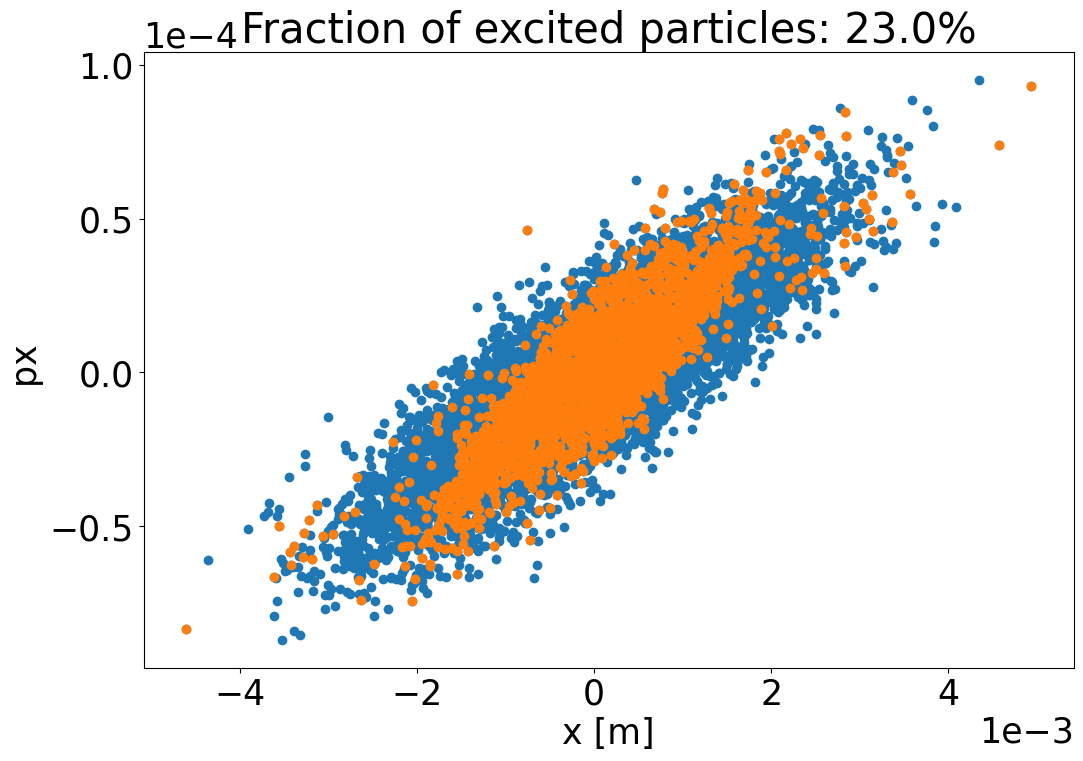

In [7]:
excited=particles.state==2

fraction_excitation = sum(excited)/len(excited)

plt.figure(figsize=(12, 8))
plt.rcParams.update({'font.size': 25})
plt.title(f'Fraction of excited particles: {fraction_excitation*100:.3}%')
plt.scatter(particles.x,particles.px)
plt.scatter(particles.x[excited],particles.px[excited])
plt.xlabel('x [m]')
plt.ylabel('px ')
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.show()